In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mdates

from itertools import islice

In [3]:
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from estimator import HopfieldEstimator

In [4]:
dataset = get_dataset("electricity")

In [8]:
estimator = HopfieldEstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    num_feat_static_cat=1,
    cardinality=[321],
    embedding_dimension=[3],
    dim_feedforward=32,
    num_encoder_layers=2,
    num_decoder_layers=2,
    nhead=2,
    activation="relu",

    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=50, accelerator='gpu', gpus=1),
)

In [9]:
predictor = estimator.train(
    training_data=dataset.train,
    num_workers=8,
    shuffle_buffer_length=1024
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestam

/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)
/home/kashif/gluon-ts-PR/src/gluonts/transform/split.py:36: Futur

Training: 0it [00:00, ?it/s]

Epoch 0, global step 99: train_loss reached 6.64344 (best 6.64344), saving model to "/mnt/scratch/kashif/pytorch-transformer-ts/hopfield/lightning_logs/version_0/checkpoints/epoch=0-step=99.ckpt" as top 1
Epoch 1, global step 199: train_loss reached 5.94193 (best 5.94193), saving model to "/mnt/scratch/kashif/pytorch-transformer-ts/hopfield/lightning_logs/version_0/checkpoints/epoch=1-step=199.ckpt" as top 1
Epoch 2, global step 299: train_loss reached 5.73109 (best 5.73109), saving model to "/mnt/scratch/kashif/pytorch-transformer-ts/hopfield/lightning_logs/version_0/checkpoints/epoch=2-step=299.ckpt" as top 1
Epoch 3, global step 399: train_loss reached 5.61180 (best 5.61180), saving model to "/mnt/scratch/kashif/pytorch-transformer-ts/hopfield/lightning_logs/version_0/checkpoints/epoch=3-step=399.ckpt" as top 1
Epoch 4, global step 499: train_loss reached 5.52999 (best 5.52999), saving model to "/mnt/scratch/kashif/pytorch-transformer-ts/hopfield/lightning_logs/version_0/checkpoints

In [10]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor
)

In [11]:
forecasts = list(forecast_it)

/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/home/kashif/gluon-ts-PR/src/gluonts/dataset/common.py:328: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/home/kashif/gluon-ts-PR/src/gluonts/transform/feature.py:343: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self._freq_base = start.freq.base
/home/kashif/gluon-ts-PR/src/gluo

In [12]:
tss = list(ts_it)

In [13]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))

Running evaluation: 100%|█████████████████| 2247/2247 [00:00<00:00, 6153.63it/s]/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  date_before_forecast = forecast.index[0] - forecast.index[0].freq
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:306

In [14]:
agg_metrics

{'MSE': 2895727.017526503,
 'abs_error': 8990004.07913351,
 'abs_target_sum': 128632956.0,
 'abs_target_mean': 2385.272140631954,
 'seasonal_error': 189.49338196116761,
 'MASE': 0.7369250889230592,
 'MAPE': 0.09753454503663234,
 'sMAPE': 0.11008293481736806,
 'MSIS': 5.87545772076946,
 'QuantileLoss[0.1]': 4102381.8261636286,
 'Coverage[0.1]': 0.12227414330218069,
 'QuantileLoss[0.2]': 6233653.918226821,
 'Coverage[0.2]': 0.2435469514908767,
 'QuantileLoss[0.3]': 7711257.692320096,
 'Coverage[0.3]': 0.35821836522771106,
 'QuantileLoss[0.4]': 8610761.914141282,
 'Coverage[0.4]': 0.4646009494140335,
 'QuantileLoss[0.5]': 8990004.051900875,
 'Coverage[0.5]': 0.5643265094199673,
 'QuantileLoss[0.6]': 8984688.211375037,
 'Coverage[0.6]': 0.6473260643821391,
 'QuantileLoss[0.7]': 8381327.075728629,
 'Coverage[0.7]': 0.7342567868268803,
 'QuantileLoss[0.8]': 7109750.714243669,
 'Coverage[0.8]': 0.8196113336300253,
 'QuantileLoss[0.9]': 4968735.700513921,
 'Coverage[0.9]': 0.9017393561786085,


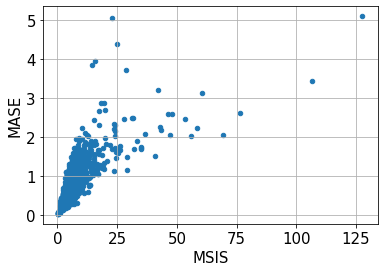

In [17]:
ts_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

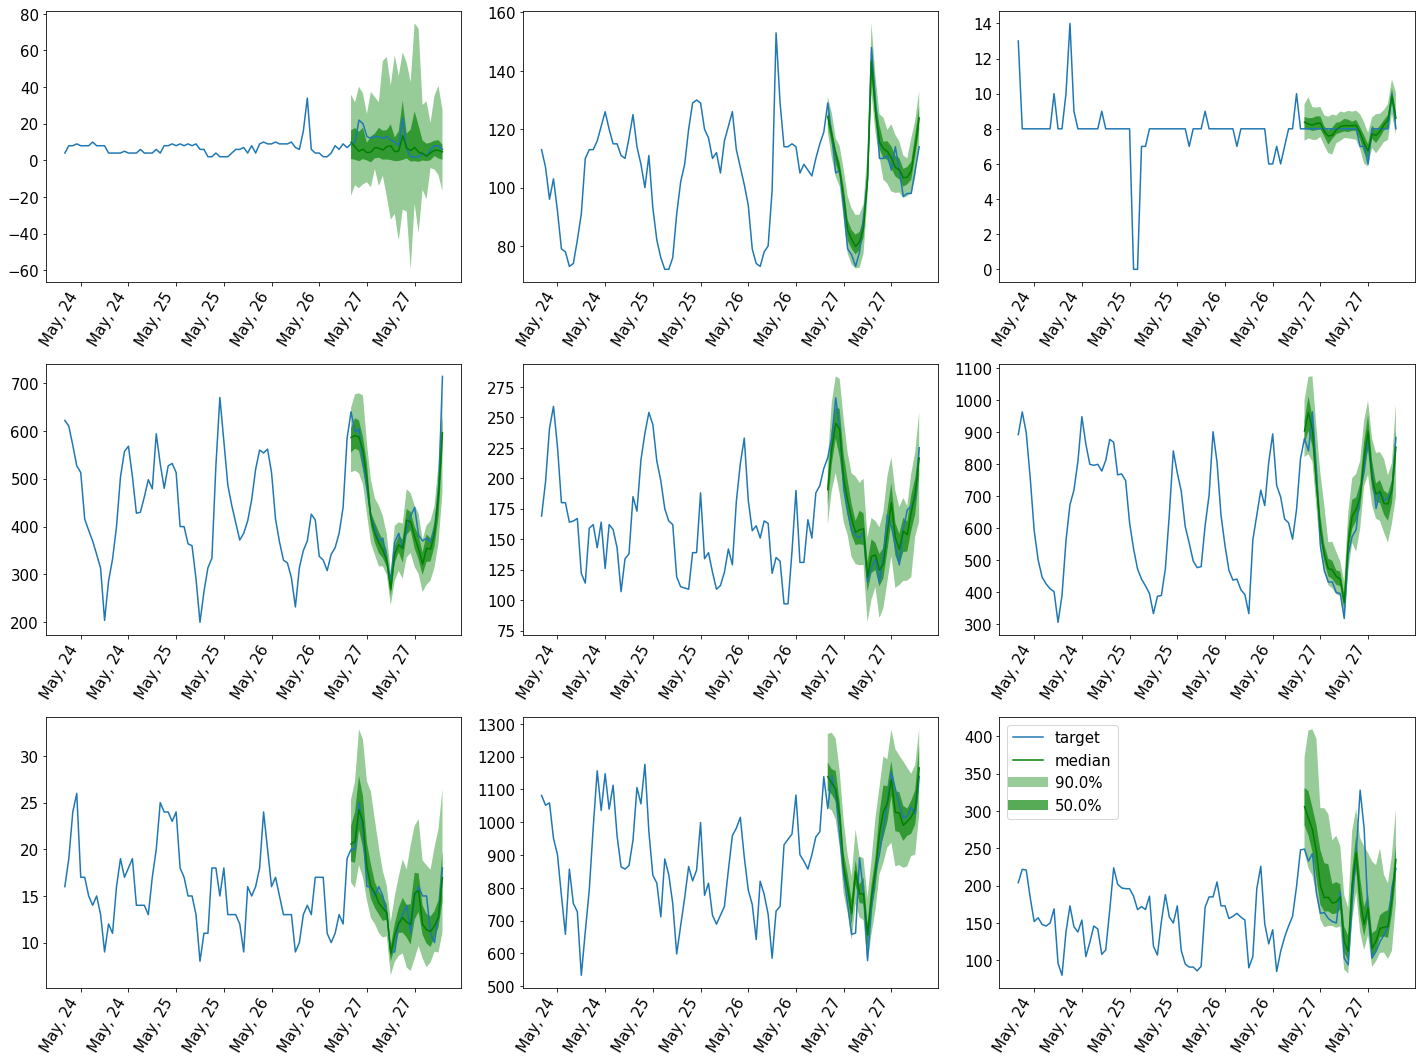

In [16]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:], label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()